## Imports

In [9]:
import os
import datetime
print(datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S'))

import time
import glob
import tables as tb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from functools import reduce

2018-06-07 00:32:25


In [10]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

plt.rcParams["figure.figsize"] = 10, 8
plt.rcParams["font.size"     ] = 14

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
from invisible_cities.database import load_db

import invisible_cities.sierpe.blr as blr

import invisible_cities.reco.tbl_functions as tbl
import invisible_cities.reco.peak_functions as pkf
import invisible_cities.reco.calib_sensors_functions as csf

from   invisible_cities.evm.ic_containers  import S12Params 
from   invisible_cities.evm.ic_containers  import CalibVectors
from   invisible_cities.evm.ic_containers  import DeconvParams
from   invisible_cities.evm.ic_containers  import ThresholdParams

from   invisible_cities.core.system_of_units_c import units
from   invisible_cities.types.ic_types import minmax
import invisible_cities.icaro.mpl_functions as mpl
import invisible_cities.icaro.signal_functions_mpl as sf
from invisible_cities.icaro.pmaps_mpl import plot_s12
from invisible_cities.sierpe                 import blr

In [12]:
from invisible_cities.reco.dst_functions  import load_dst

In [13]:
from invisible_cities.evm .pmaps             import S1
from invisible_cities.evm .pmaps             import S2

## NB functions

In [14]:
def plot_csum_csum_mau(csum, csum_mau,
                            t_min      =    0,
                            t_max      = 1200,
                            signal_min =    0,
                            signal_max =  200,
                            figsize=(6,6)):
    """Plot signal versus time in mus (tmin, tmax in mus). """
    plt.figure(figsize=figsize)
    tstep = 25 # in ns
    PMTWL = csum.shape[0]
    signal_t = np.arange(0., PMTWL * tstep, tstep)/units.mus
    ax1 = plt.subplot(1, 1, 1)
    ax1.set_xlim([t_min, t_max])
    ax1.set_ylim([signal_min, signal_max])
    mpl.set_plot_labels(xlabel = "t (mus)",
                    ylabel = "signal (pes/adc)")
    plt.plot(signal_t, csum, 'b')
    plt.plot(signal_t, csum_mau, 'r')

In [15]:
def plot_S12(s12s):
    plt.grid(True)
    plt.xlabel(r't (ns)')
    plt.ylabel(r'q (pes)')
    for s12 in s12s:
        plt.plot(s12.times, s12.pmts.waveform(-1))

In [16]:
def plot_pmt_signals_vs_time_mus(pmt_signals,
                                 pmt_active,
                                 t_min      =    0,
                                 t_max      = 1200,
                                 signal_min =    0,
                                 signal_max =  200,
                                 figsize=(12,12)):
    """Plot PMT signals versus time in mus  and return figure."""

    tstep = 25
    PMTWL = pmt_signals[0].shape[0]
    signal_t = np.arange(0., PMTWL * tstep, tstep)/units.mus
    plt.figure(figsize=figsize)
   
   
    plt.ylabel(r'q (pes/adc)')
    for j, i in enumerate(pmt_active):
        plt.grid(True)
        ax1 = plt.subplot(3, 4, j+1)
        ax1.set_xlim([t_min, t_max])
        ax1.set_ylim([signal_min, signal_max])
        plt.plot(signal_t, pmt_signals[i])
        plt.xlabel(r't (mus)')


In [17]:
def plot_pmt_waveforms(pmtwfdf, first=0, last=50000, figsize=(10,10)):
    """plot PMT wf and return figure"""
    plt.figure(figsize=figsize)
    for i in range(len(pmtwfdf)):
        ax = plt.subplot(3, 4, i+1)
        plt.xlabel(r't (mus)')
        plt.plot(pmtwfdf[i][first:last])


In [18]:
def plot_sipm_map(sipm_cal, t_min=0, t_max=1300, zoom=False):
    
    sipm_sums_w = np.sum(sipm_cal[:, t_min:t_max], axis=1)
    
    plt.figure()
    sipms_ = sipm_sums_w > 0 
    x = xs[sipms_]
    y = ys[sipms_]
    q = sipm_sums_w[sipms_]
    print(np.argwhere(sipms_))
    plt.scatter(x, y, s=10, c=q, cmap="jet")
    
    if not zoom:
        plt.xlim(-200, 200)
        plt.ylim(-200, 200)
    plt.colorbar()

## Data base

In [19]:
run_number = 5781
DataPMT = load_db.DataPMT(run_number)
DataSiPM = load_db.DataSiPM(run_number)
xs = DataSiPM.X.values
ys = DataSiPM.Y.values
pmt_active = np.nonzero(DataPMT.Active.values)[0].tolist()

In [20]:
channel_id = DataPMT.ChannelID.values
coeff_blr = abs(DataPMT.coeff_blr.values)
coeff_c = abs(DataPMT.coeff_c .values)
adc_to_pes = abs(DataPMT.adc_to_pes.values)
adc_to_pes_sipm = abs(DataSiPM.adc_to_pes.values)

In [21]:
DataPMT

,SensorID,ChannelID,PmtID,Active,X,Y,coeff_blr,coeff_c,adc_to_pes,noise_rms,Sigma
0,0,0,PMT1,1,-23.9414,65.7785,0.000530,4.250400e-07,21.33,0.77,11.33
1,1,12,PMT3,1,-44.9951,-53.6231,0.000533,3.599900e-07,23.37,0.00,11.54
2,2,1,PMT2,1,68.9365,-12.1554,0.000530,5.525500e-07,26.02,0.81,10.62
3,3,13,PMT4,1,0.0000,185.0000,0.000526,3.563900e-07,25.74,0.00,11.86
4,4,19,PMTC,1,-118.9160,141.7180,0.000520,3.804100e-07,30.00,0.75,13.15
5,5,18,PMTB,1,-182.1890,32.1249,0.000529,5.704900e-07,22.66,0.75,9.88
6,6,7,PMTA,1,-160.2150,-92.5000,0.000518,5.597400e-07,25.09,0.00,11.04
7,7,6,PMT9,1,-63.2737,-173.8430,0.000528,5.918400e-07,32.66,0.00,14.72
8,8,2,PMT8,1,63.2737,-173.8430,0.000525,4.849600e-07,23.10,0.00,10.60
9,9,16,PMT7,1,160.2150,-92.5000,0.000527,4.763500e-07,25.47,0.00,10.37


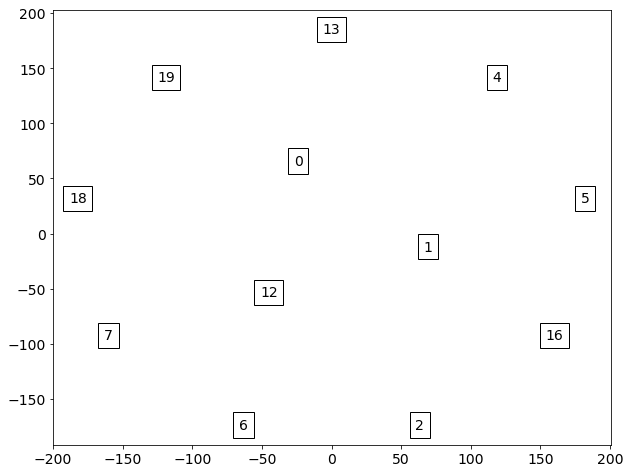

In [22]:
mpl.draw_pmt_map(run_number)

In [23]:
pmt_active

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

In [24]:
adc_to_pes

array([ 21.33,  23.37,  26.02,  25.74,  30.  ,  22.66,  25.09,  32.66,
        23.1 ,  25.47,  20.8 ,  21.99])

In [25]:
sipm_adc_to_pes = DataSiPM.adc_to_pes.values

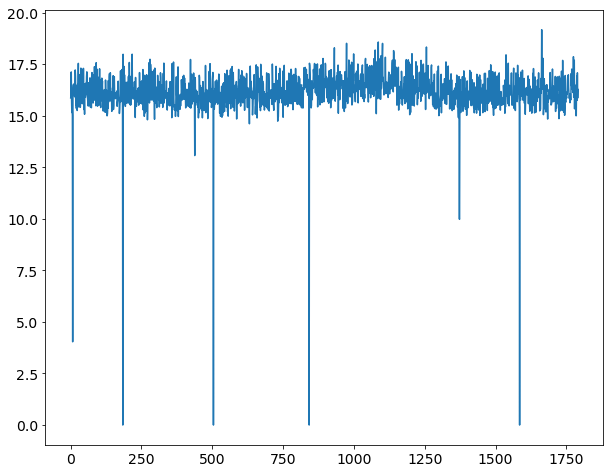

In [26]:
plt.plot(adc_to_pes_sipm)

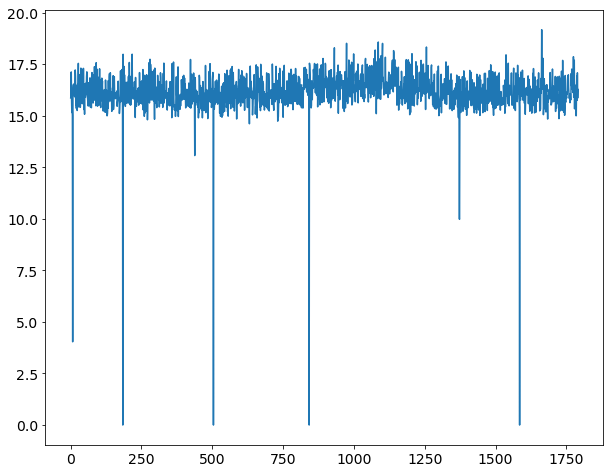

In [27]:
plt.plot(sipm_adc_to_pes)

## Input file

In [28]:
filename = '/Users/jjgomezcadenas/Projects/ICDEV/data/5781/run_5781_0122_waveforms.h5'
input_files = [filename]
h5rwf = tb.open_file(filename, "r") 

In [29]:
pmtrwf = h5rwf.root.RD.pmtrwf
sipmrwf = h5rwf.root.RD.sipmrwf

In [30]:
NEVT, NPMT, PMTWL = pmtrwf.shape
_, NSIPM, SIPMWL = sipmrwf.shape

In [31]:
print("""
        Number of events in file = {}
        Number of PMTs = {}
        PMTWL = {}
        Number of SiPMs = {}
        SiPMWL = {}
      """.format(NEVT, NPMT, PMTWL, NSIPM, SIPMWL))


        Number of events in file = 164
        Number of PMTs = 12
        PMTWL = 52000
        Number of SiPMs = 1792
        SiPMWL = 1300
      


## S1 and S2 parameters

In [32]:
s1params = S12Params(time = minmax(min    = 0 * units.mus,
                                   max    = 640 * units.mus),
                           stride = 4,
                           length = minmax(min = 5, max = 20),  #250 ns -- 50 ns
                           rebin_stride  = 1)

In [33]:
s2params = S12Params(time = minmax(min    = 640 * units.mus,
                                   max    = 800 * units.mus),
                           stride = 40,
                           length = minmax(min = 80, max = 1e5),  # 4 mus --
                           rebin_stride  = 40)

## Events

## Event 1

In [34]:
event=1

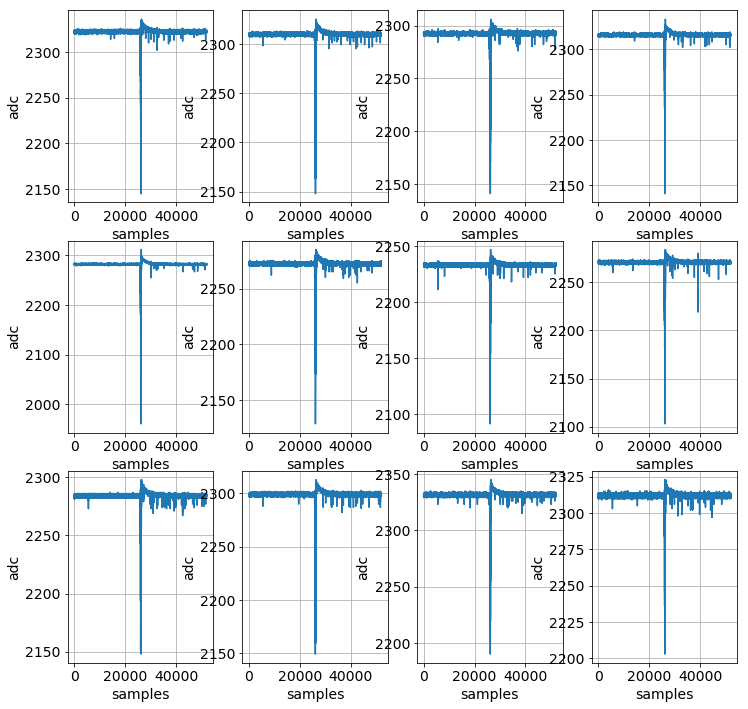

In [35]:
sf.plot_pmt_waveforms(pmtrwf[event], zoom=False, window_size=800, figsize=(12,12))

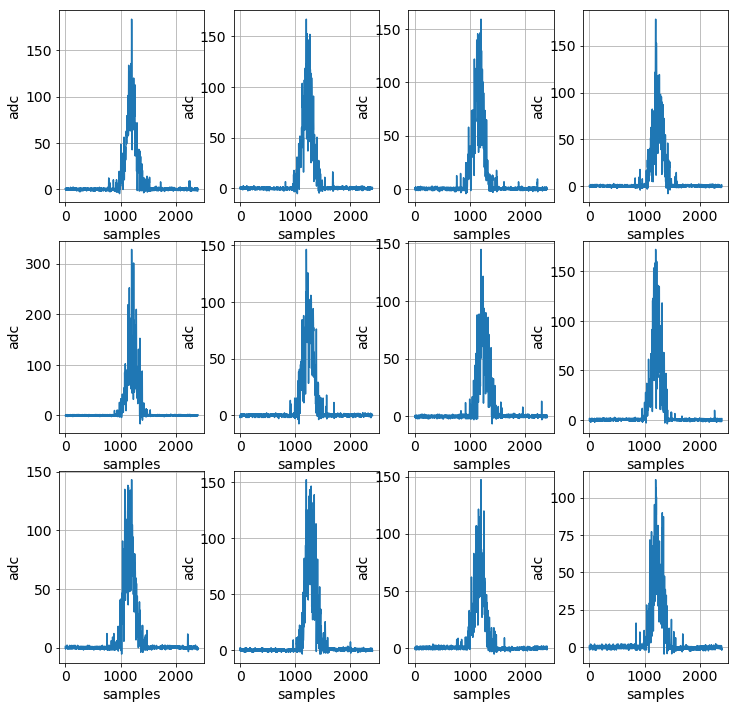

In [36]:
CWF  = blr.deconv_pmt(pmtrwf[event], coeff_c, coeff_blr, pmt_active, 
                      n_baseline            = 48000,
                      thr_trigger           =     5,
                      accum_discharge_length =  5000)

sf.plot_pmt_waveforms(CWF, zoom=True, window_size=1200, figsize=(12,12))

- Calibrated signal in all PMTs

In [37]:
ccwfs, ccwfs_mau, cwf_sum, cwf_sum_mau = csf.calibrate_pmts(CWF, adc_to_pes, n_MAU = 100, thr_MAU = 3)

- Calibrated sum

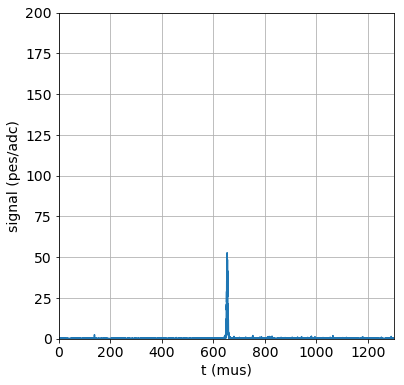

In [38]:
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =0,
                            t_max      = 1300,
                            signal_min =    0,
                            signal_max =  200,
                            figsize=(6,6))

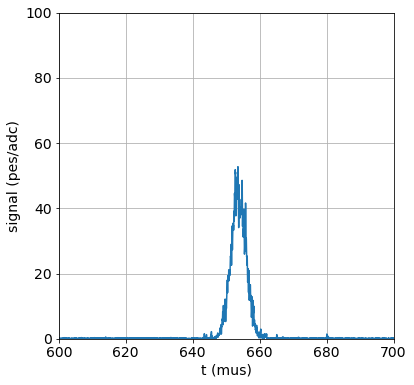

In [39]:
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =600,
                            t_max      = 700,
                            signal_min =    0,
                            signal_max =  100,
                            figsize=(6,6))

- Zoom to the S1 signal shows a problem. S1 has a "double peak structure"

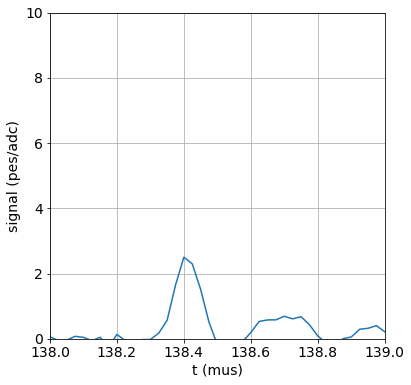

In [42]:
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =138,
                            t_max      = 139,
                            signal_min =   0,
                            signal_max =  10,
                            figsize=(6,6))

#### Search for S1 and S2a

In [49]:
s1_indx, s1_ene = pkf.indices_and_wf_above_threshold(cwf_sum_mau, 0.5 * units.pes)

In [50]:
s1s = pkf.find_peaks(cwf_sum, s1_indx, s1params.time, s1params.length, s1params.stride, s1params.rebin_stride,
                    Pk=S1, pmt_ids=[-1], sipm_wfs=None, thr_sipm_s2=0)

- Algorithm finds 1 S1s 

In [51]:
s1s

[]

In [46]:
s2_indx, s2_ene = pkf.indices_and_wf_above_threshold(cwf_sum, 1.0 * units.pes)

In [47]:
s2s = pkf.find_peaks(cwf_sum, s2_indx, s2params.time, s2params.length, s2params.stride, s2params.rebin_stride,
                    Pk=S2, pmt_ids=[-1], sipm_wfs=None, thr_sipm_s2=0)

In [48]:
s2s

[
       ---------------------
       S2 instance
       ---------------------
       Number of samples: 15
       Times: [ 647.83360923  648.86114373  649.7949773   650.76593193  651.76810028
 652.75449668  653.71977836  654.72124972  655.71330772  656.69964858
 657.71470697  658.66247517  659.7201684   660.60915222  661.7307738 ] µs
       Time @ max energy: 652.7544966840011
       Width: 13.897164566522232 µs
       Height: 1779.65882344846 pes
       Energy: 10133.802016186159 pes
       Charge: 0.0 pes
       RMS: 2.287197211746308 µs]

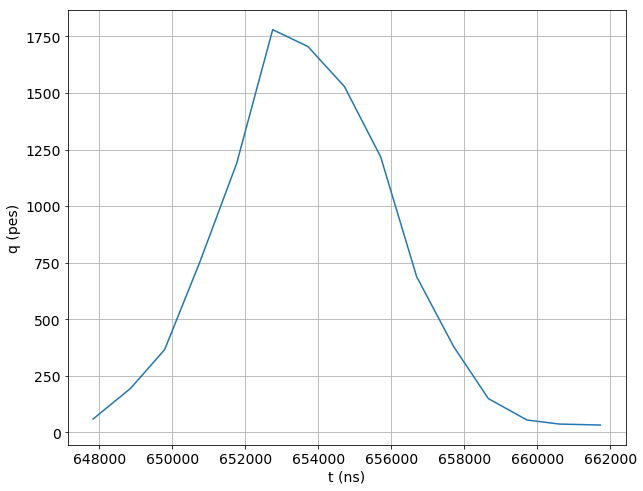

In [52]:
plot_S12(s2s)

In [53]:
sipm_cal = csf.calibrate_sipms(sipmrwf[event], sipm_adc_to_pes, thr=5,
                          bls_mode=csf.BlsMode.mode)

[[   7]
 [ 335]
 [ 400]
 [ 401]
 [ 402]
 [ 408]
 [ 409]
 [ 410]
 [ 411]
 [ 417]
 [ 418]
 [ 653]
 [1064]
 [1500]]


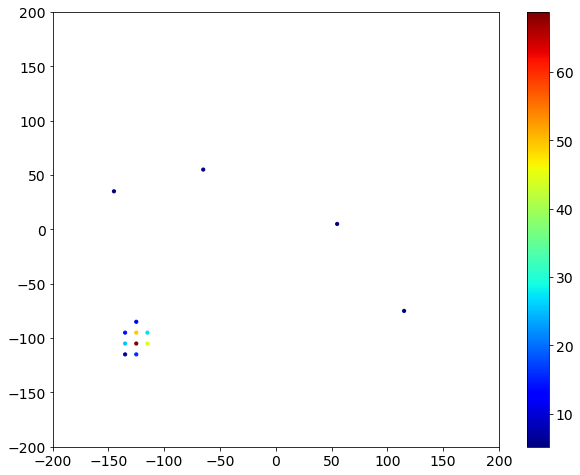

In [54]:
plot_sipm_map(sipm_cal)

## Event 2

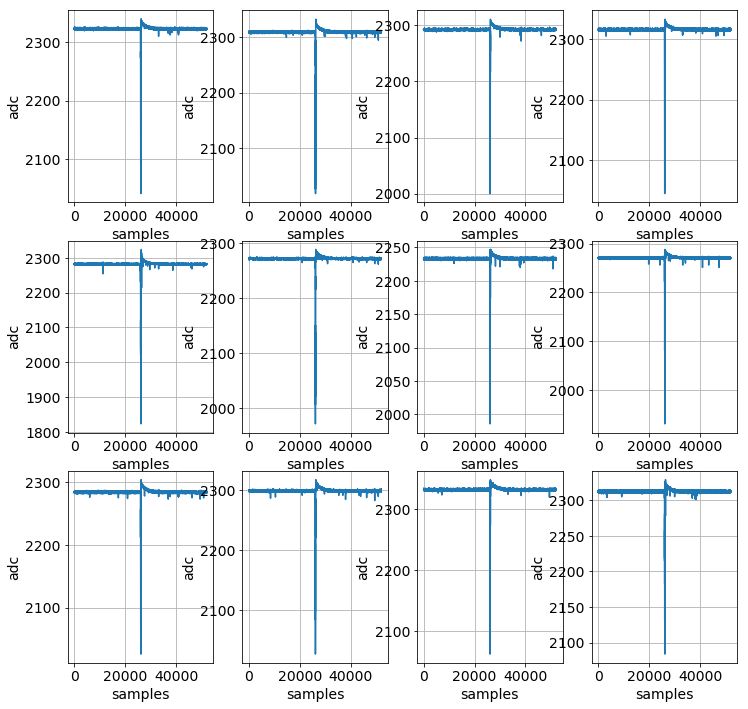

In [55]:
event=2
sf.plot_pmt_waveforms(pmtrwf[event], zoom=False, window_size=800, figsize=(12,12))

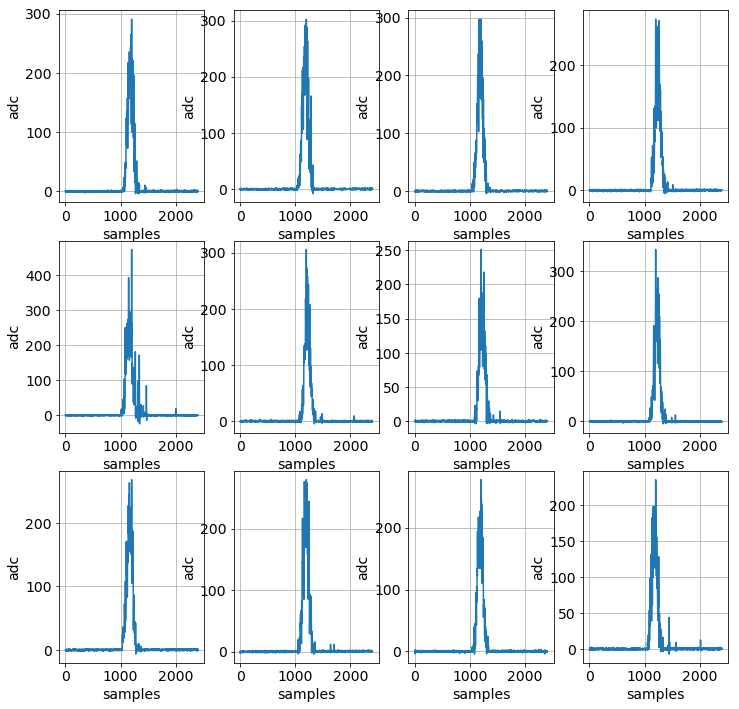

In [56]:
CWF  = blr.deconv_pmt(pmtrwf[event], coeff_c, coeff_blr, pmt_active, 
                      n_baseline            = 48000,
                      thr_trigger           =     5,
                      accum_discharge_length =  5000)
sf.plot_pmt_waveforms(CWF, zoom=True, window_size=1200, figsize=(12,12))

In [57]:
ccwfs, ccwfs_mau, cwf_sum, cwf_sum_mau = csf.calibrate_pmts(CWF, adc_to_pes)

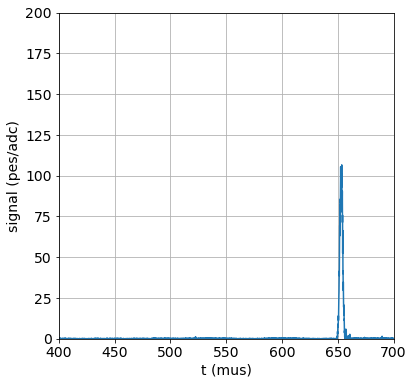

In [58]:
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =400,
                            t_max      = 700,
                            signal_min =    0,
                            signal_max =  200,
                            figsize=(6,6))

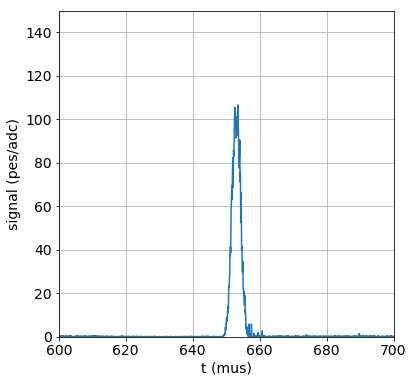

In [59]:
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =600,
                            t_max      = 700,
                            signal_min =    0,
                            signal_max =  150,
                            figsize=(6,6))

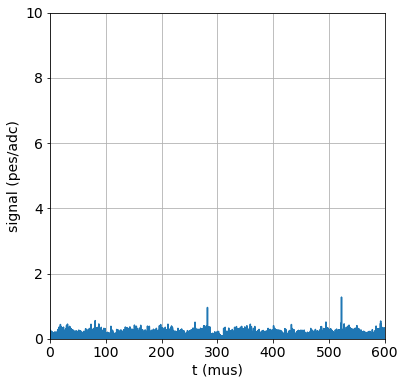

In [60]:
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =0,
                            t_max      = 600,
                            signal_min =    0,
                            signal_max =  10,
                            figsize=(6,6))

In [61]:
s1_indx, s1_ene = pkf.indices_and_wf_above_threshold(cwf_sum_mau, 0.5 * units.pes)
s1s = pkf.find_peaks(cwf_sum, s1_indx, s1params.time, s1params.length, s1params.stride, s1params.rebin_stride,
                    Pk=S1, pmt_ids=[-1], sipm_wfs=None, thr_sipm_s2=0)
s1s

[]

In [62]:
s2_indx, s2_ene = pkf.indices_and_wf_above_threshold(cwf_sum, 1.0 * units.pes)
s2s = pkf.find_peaks(cwf_sum, s2_indx, s2params.time, s2params.length, s2params.stride, s2params.rebin_stride,
                    Pk=S2, pmt_ids=[-1], sipm_wfs=None, thr_sipm_s2=0)
s2s

[
       ---------------------
       S2 instance
       ---------------------
       Number of samples: 9
       Times: [ 650.05900888  651.0008934   651.9242058   652.88157174  653.84189644
 654.7764489   655.70661923  656.76195336  657.61637245] µs
       Time @ max energy: 652.8815717372803
       Width: 7.5573635717665315 µs
       Height: 3921.9359840110346 pes
       Energy: 13154.176670761553 pes
       Charge: 0.0 pes
       RMS: 1.2212914316593655 µs]

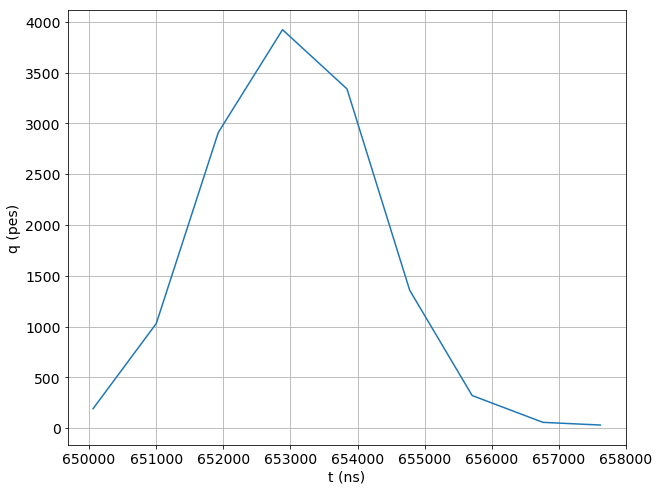

In [63]:
plot_S12(s2s)

#### Search for S2 can use a threshold a bit higher (1 pes) to avoid tails. 

## Event 3

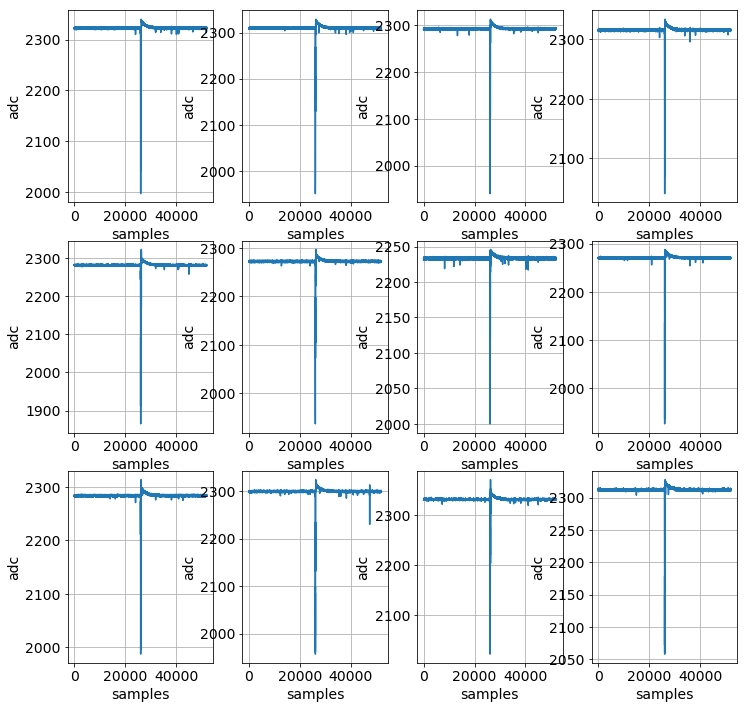

In [64]:
event=3
sf.plot_pmt_waveforms(pmtrwf[event], zoom=False, window_size=800, figsize=(12,12))

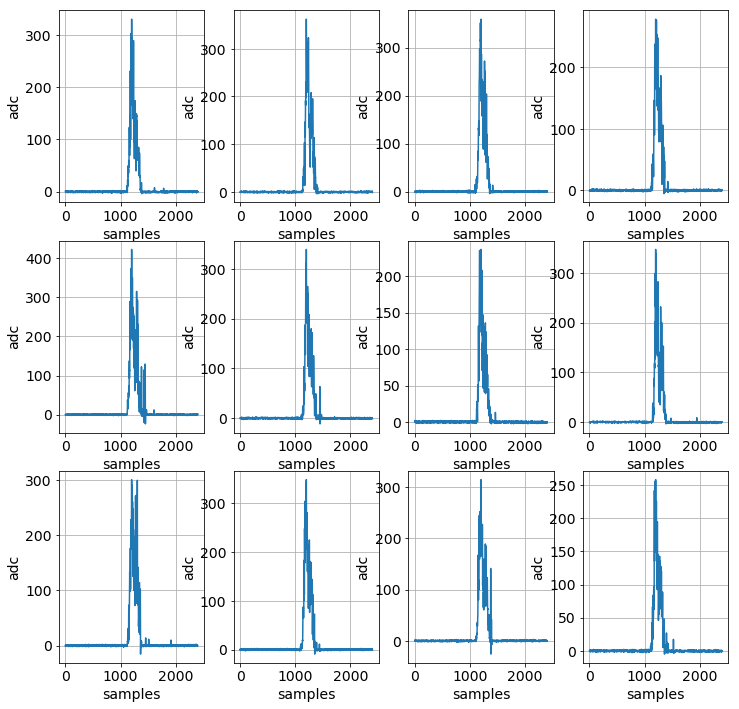

In [272]:
CWF  = blr.deconv_pmt(pmtrwf[event], coeff_c, coeff_blr, pmt_active, 
                      n_baseline            = 48000,
                      thr_trigger           =     5,
                      accum_discharge_length =  5000)
sf.plot_pmt_waveforms(CWF, zoom=True, window_size=1200, figsize=(12,12))

In [273]:
ccwfs, ccwfs_mau, cwf_sum, cwf_sum_mau = csf.calibrate_pmts(CWF, adc_to_pes)

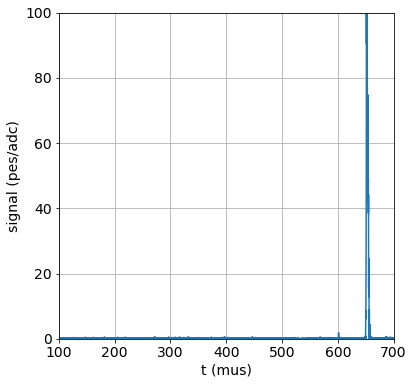

In [274]:
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =100,
                            t_max      = 700,
                            signal_min =    0,
                            signal_max =  100,
                            figsize=(6,6))

In [276]:
s1_indx, s1_ene = pkf.indices_and_wf_above_threshold(cwf_sum_mau, 0.5 * units.pes)
s1s = pkf.find_peaks(cwf_sum, s1_indx, s1params.time, s1params.length, s1params.stride, s1params.rebin_stride,
                    Pk=S1, pmt_ids=[-1], sipm_wfs=None, thr_sipm_s2=0)
s1s

[
       ---------------------
       S1 instance
       ---------------------
       Number of samples: 9
       Times: [ 601.325  601.35   601.375  601.4    601.425  601.45   601.475  601.5
 601.525] µs
       Time @ max energy: 601.375
       Width: 0.2 µs
       Height: 1.8628225460472239 pes
       Energy: 10.440681859103885 pes
       Charge: 0.0 pes
       RMS: 0.056988779375967774 µs]

In [278]:
s2_indx, s2_ene = pkf.indices_and_wf_above_threshold(cwf_sum, 1.0 * units.pes)
s2s = pkf.find_peaks(cwf_sum, s2_indx, s2params.time, s2params.length, s2params.stride, s2params.rebin_stride,
                    Pk=S2, pmt_ids=[-1], sipm_wfs=None, thr_sipm_s2=0)
s2s

[
       ---------------------
       S2 instance
       ---------------------
       Number of samples: 9
       Times: [ 650.49583658  651.39159564  652.25511772  653.2675588   654.25173162
 655.1877336   656.12613099  657.32485998  658.03369717] µs
       Time @ max energy: 652.2551177215096
       Width: 7.537860589347082 µs
       Height: 4366.253022316394 pes
       Energy: 14189.772632700415 pes
       Charge: 0.0 pes
       RMS: 1.3198464051192602 µs]

- This appears to be an OK event, but energy smaller than others (however, notice lack of topological cuts)

## Event 4

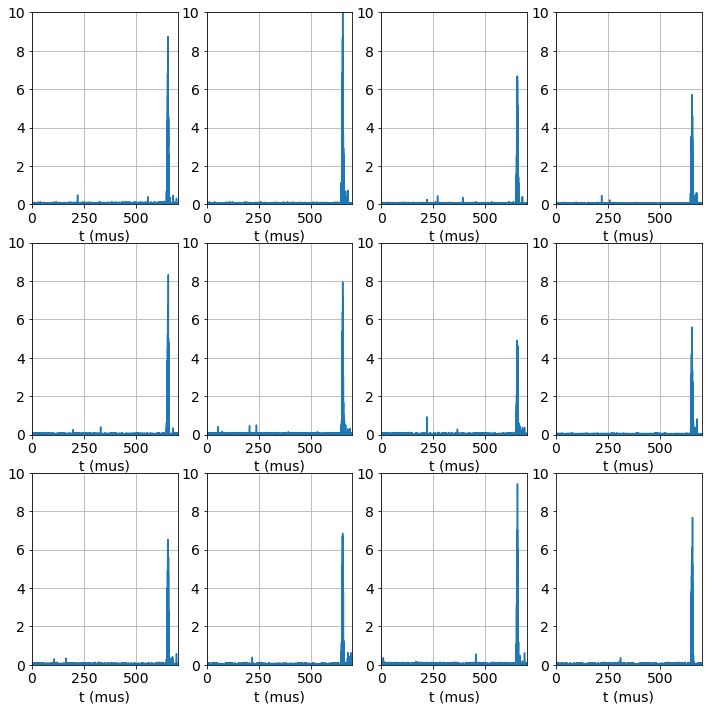

In [279]:
event=4
CWF  = blr.deconv_pmt(pmtrwf[event], coeff_c, coeff_blr, pmt_active, 
                      n_baseline            = 48000,
                      thr_trigger           =     5,
                      accum_discharge_length =  5000)
ccwfs, ccwfs_mau, cwf_sum, cwf_sum_mau = csf.calibrate_pmts(CWF, adc_to_pes)
plot_pmt_signals_vs_time_mus(ccwfs,
                                pmt_active,
                                t_min      =    0,
                                t_max      = 700,
                                signal_min =    0,
                                signal_max =  10,
                                 figsize=(12,12))

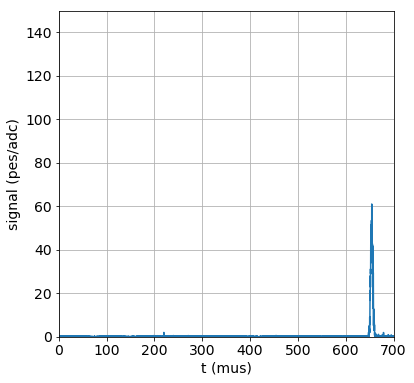

In [280]:
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =0,
                            t_max      = 700,
                            signal_min =    0,
                            signal_max =  150,
                            figsize=(6,6))

In [281]:
s1_indx, s1_ene = pkf.indices_and_wf_above_threshold(cwf_sum_mau, 0.5 * units.pes)
s1s = pkf.find_peaks(cwf_sum, s1_indx, s1params.time, s1params.length, s1params.stride, s1params.rebin_stride,
                    Pk=S1, pmt_ids=[-1], sipm_wfs=None, thr_sipm_s2=0)
s1s

[
 ---------------------
 S1 instance
 ---------------------
 Number of samples: 7
 Times: [ 219.525  219.55   219.575  219.6    219.625  219.65   219.675] µs
 Time @ max energy: 219.575
 Width: 0.15 µs
 Height: 2.011420638689399 pes
 Energy: 9.003920059069157 pes
 Charge: 0.0 pes
 RMS: 0.0401101693295252 µs]

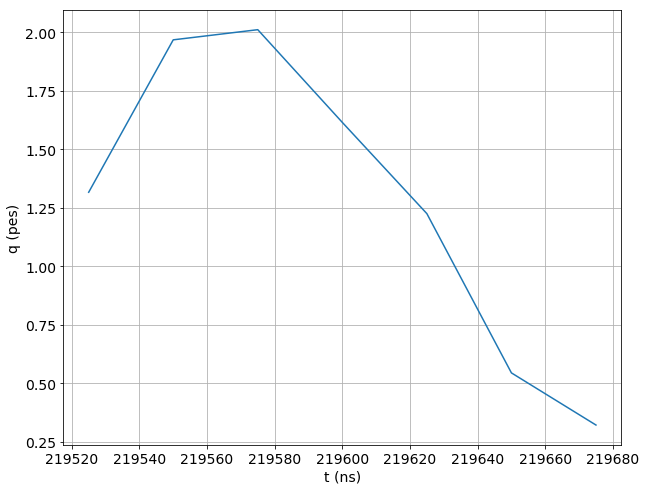

In [282]:
plot_S12(s1s)

In [283]:
s2_indx, s2_ene = pkf.indices_and_wf_above_threshold(cwf_sum, 1.0 * units.pes)
s2s = pkf.find_peaks(cwf_sum, s2_indx, s2params.time, s2params.length, s2params.stride, s2params.rebin_stride,
                    Pk=S2, pmt_ids=[-1], sipm_wfs=None, thr_sipm_s2=0)
s2s

[
       ---------------------
       S2 instance
       ---------------------
       Number of samples: 14
       Times: [ 648.10374014  649.0484429   650.1481952   651.08132189  652.06904017
 653.05521789  654.05385052  654.99717438  656.02344465  656.99057925
 657.97227829  658.98027094  659.87872889  660.66579713] µs
       Time @ max energy: 654.0538505158823
       Width: 12.562056989027885 µs
       Height: 2030.1133210312357 pes
       Energy: 11528.733902597185 pes
       Charge: 0.0 pes
       RMS: 2.2048346687909492 µs]

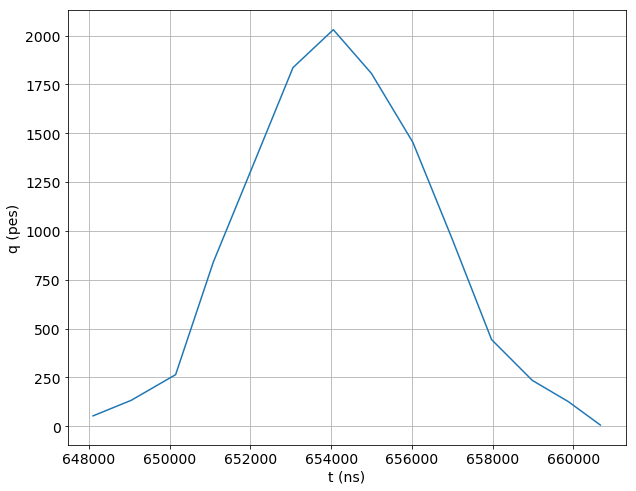

In [284]:
plot_S12(s2s)

## Event 5

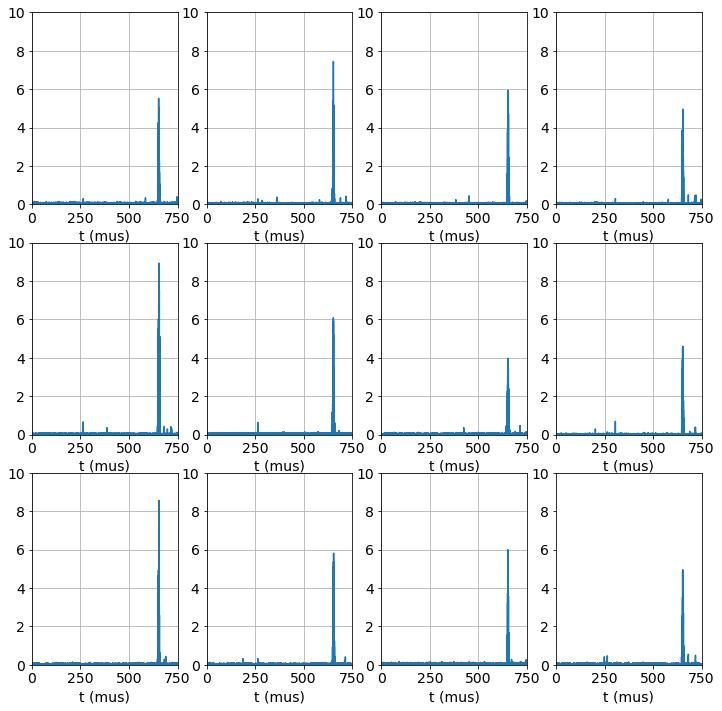

In [285]:
event=5
CWF  = blr.deconv_pmt(pmtrwf[event], coeff_c, coeff_blr, pmt_active, 
                      n_baseline            = 48000,
                      thr_trigger           =     5,
                      accum_discharge_length =  5000)
ccwfs, ccwfs_mau, cwf_sum, cwf_sum_mau = csf.calibrate_pmts(CWF, adc_to_pes)
plot_pmt_signals_vs_time_mus(ccwfs,
                                pmt_active,
                                t_min      =    0,
                                t_max      = 750,
                                signal_min =    0,
                                signal_max =  10,
                                 figsize=(12,12))

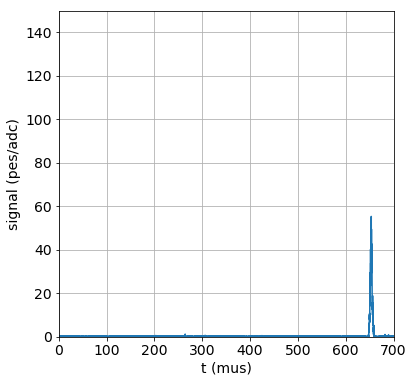

In [286]:
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =0,
                            t_max      = 700,
                            signal_min =    0,
                            signal_max =  150,
                            figsize=(6,6))

In [287]:
s1_indx, s1_ene = pkf.indices_and_wf_above_threshold(cwf_sum_mau, 0.5 * units.pes)
s1s = pkf.find_peaks(cwf_sum, s1_indx, s1params.time, s1params.length, s1params.stride, s1params.rebin_stride,
                    Pk=S1, pmt_ids=[-1], sipm_wfs=None, thr_sipm_s2=0)
s1s

[
 ---------------------
 S1 instance
 ---------------------
 Number of samples: 6
 Times: [ 264.15   264.175  264.2    264.225  264.25   264.275] µs
 Time @ max energy: 264.2
 Width: 0.125 µs
 Height: 1.2525161410919883 pes
 Energy: 5.560842656449511 pes
 Charge: 0.0 pes
 RMS: 0.038299132598762685 µs]

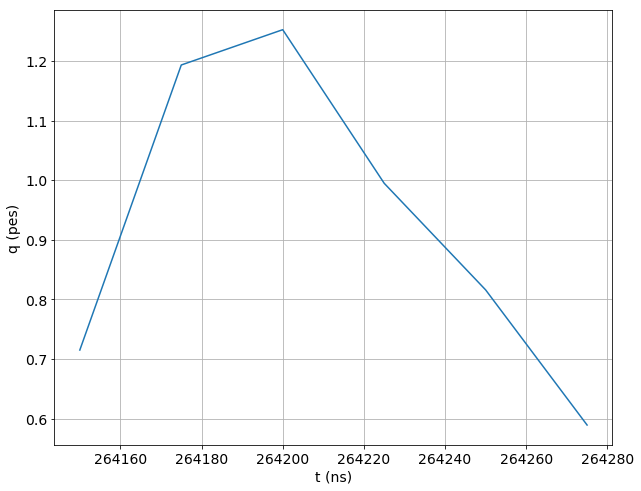

In [288]:
plot_S12(s1s)

In [290]:
s2_indx, s2_ene = pkf.indices_and_wf_above_threshold(cwf_sum, 1.0 * units.pes)
s2s = pkf.find_peaks(cwf_sum, s2_indx, s2params.time, s2params.length, s2params.stride, s2params.rebin_stride,
                    Pk=S2, pmt_ids=[-1], sipm_wfs=None, thr_sipm_s2=0)
s2s

[
       ---------------------
       S2 instance
       ---------------------
       Number of samples: 12
       Times: [ 648.62831187  649.60234078  650.61960168  651.60732475  652.59058972
 653.54731837  654.52641974  655.5364635   656.46126895  657.46208184
 658.58368249  658.27187323] µs
       Time @ max energy: 653.5473183669083
       Width: 9.955370616634841 µs
       Height: 1620.1186794293976 pes
       Energy: 7858.408921231527 pes
       Charge: 0.0 pes
       RMS: 1.9857086000352235 µs]

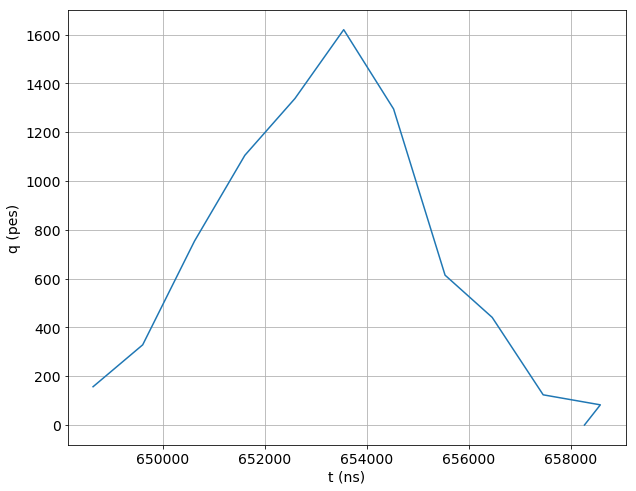

In [291]:
plot_S12(s2s)

## Event 6

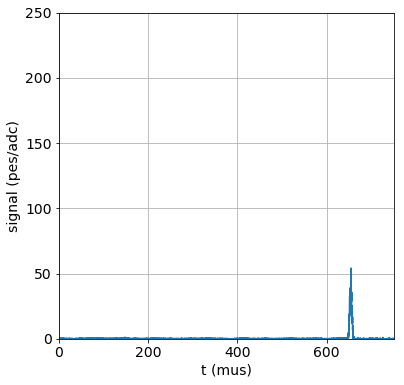

In [292]:
event=6
CWF  = blr.deconv_pmt(pmtrwf[event], coeff_c, coeff_blr, pmt_active, 
                      n_baseline            = 48000,
                      thr_trigger           =     5,
                      accum_discharge_length =  5000)
ccwfs, ccwfs_mau, cwf_sum, cwf_sum_mau = csf.calibrate_pmts(CWF, adc_to_pes)
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =0,
                            t_max      = 750,
                            signal_min =    0,
                            signal_max =  250,
                            figsize=(6,6))

In [293]:
s1_indx, s1_ene = pkf.indices_and_wf_above_threshold(cwf_sum_mau, 0.5 * units.pes)
s1s = pkf.find_peaks(cwf_sum, s1_indx, s1params.time, s1params.length, s1params.stride, s1params.rebin_stride,
                    Pk=S1, pmt_ids=[-1], sipm_wfs=None, thr_sipm_s2=0)
s1s

[
       ---------------------
       S1 instance
       ---------------------
       Number of samples: 9
       Times: [ 148.175  148.2    148.225  148.25   148.275  148.3    148.325  148.35
 148.375] µs
       Time @ max energy: 148.325
       Width: 0.2 µs
       Height: 1.3230243714166916 pes
       Energy: 9.56123685695749 pes
       Charge: 0.0 pes
       RMS: 0.05803174868451179 µs]

In [294]:
s2_indx, s2_ene = pkf.indices_and_wf_above_threshold(cwf_sum, 1.0 * units.pes)
s2s = pkf.find_peaks(cwf_sum, s2_indx, s2params.time, s2params.length, s2params.stride, s2params.rebin_stride,
                    Pk=S2, pmt_ids=[-1], sipm_wfs=None, thr_sipm_s2=0)
s2s

[
       ---------------------
       S2 instance
       ---------------------
       Number of samples: 14
       Times: [ 647.5343092   648.73003236  649.71075771  650.7077114   651.68217348
 652.67456558  653.66498223  654.63874803  655.63326472  656.62781564
 657.59582746  658.59101275  659.52714001  660.36128583] µs
       Time @ max energy: 654.6387480258016
       Width: 12.826976631960482 µs
       Height: 1518.413732626559 pes
       Energy: 9355.545086063197 pes
       Charge: 0.0 pes
       RMS: 2.283648214650391 µs]

## Event 7

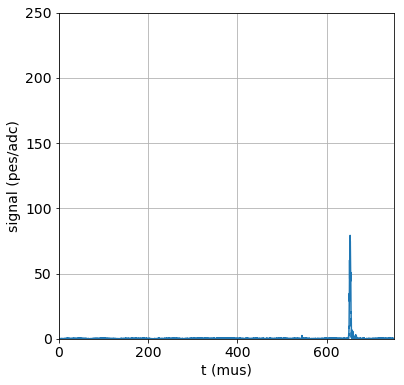

In [295]:
event=7
CWF  = blr.deconv_pmt(pmtrwf[event], coeff_c, coeff_blr, pmt_active, 
                      n_baseline            = 48000,
                      thr_trigger           =     5,
                      accum_discharge_length =  5000)
ccwfs, ccwfs_mau, cwf_sum, cwf_sum_mau = csf.calibrate_pmts(CWF, adc_to_pes)
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =0,
                            t_max      = 750,
                            signal_min =    0,
                            signal_max =  250,
                            figsize=(6,6))

In [296]:
s1_indx, s1_ene = pkf.indices_and_wf_above_threshold(cwf_sum_mau, 0.5 * units.pes)
s1s = pkf.find_peaks(cwf_sum, s1_indx, s1params.time, s1params.length, s1params.stride, s1params.rebin_stride,
                    Pk=S1, pmt_ids=[-1], sipm_wfs=None, thr_sipm_s2=0)
s1s

[
       ---------------------
       S1 instance
       ---------------------
       Number of samples: 11
       Times: [ 544.7    544.725  544.75   544.775  544.8    544.825  544.85   544.875
 544.9    544.925  544.95 ] µs
       Time @ max energy: 544.75
       Width: 0.25 µs
       Height: 2.4983535474677554 pes
       Energy: 15.37387711929477 pes
       Charge: 0.0 pes
       RMS: 0.06881291970155648 µs]

In [297]:
s2_indx, s2_ene = pkf.indices_and_wf_above_threshold(cwf_sum, 1.0 * units.pes)
s2s = pkf.find_peaks(cwf_sum, s2_indx, s2params.time, s2params.length, s2params.stride, s2params.rebin_stride,
                    Pk=S2, pmt_ids=[-1], sipm_wfs=None, thr_sipm_s2=0)
s2s

[
       ---------------------
       S2 instance
       ---------------------
       Number of samples: 8
       Times: [ 649.47399869  650.48086139  651.38706964  652.3469753   653.29880857
 654.24626249  655.20344816  656.04981505] µs
       Time @ max energy: 652.3469752982218
       Width: 6.575816364205326 µs
       Height: 2837.5670098497294 pes
       Energy: 9354.63152196649 pes
       Charge: 0.0 pes
       RMS: 1.2065653292825416 µs]

## Event 8

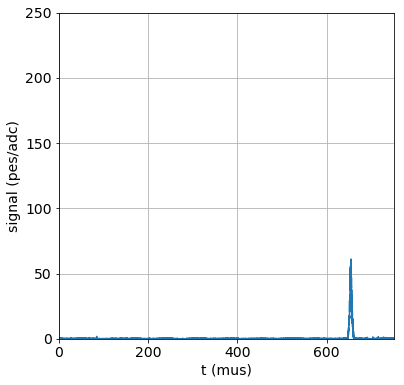

In [298]:
event=8
CWF  = blr.deconv_pmt(pmtrwf[event], coeff_c, coeff_blr, pmt_active, 
                      n_baseline            = 48000,
                      thr_trigger           =     5,
                      accum_discharge_length =  5000)
ccwfs, ccwfs_mau, cwf_sum, cwf_sum_mau = csf.calibrate_pmts(CWF, adc_to_pes)
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =0,
                            t_max      = 750,
                            signal_min =    0,
                            signal_max =  250,
                            figsize=(6,6))

In [299]:
s1_indx, s1_ene = pkf.indices_and_wf_above_threshold(cwf_sum_mau, 0.5 * units.pes)
s1s = pkf.find_peaks(cwf_sum, s1_indx, s1params.time, s1params.length, s1params.stride, s1params.rebin_stride,
                    Pk=S1, pmt_ids=[-1], sipm_wfs=None, thr_sipm_s2=0)
s1s

[
       ---------------------
       S1 instance
       ---------------------
       Number of samples: 15
       Times: [ 84.825  84.85   84.875  84.9    84.925  84.95   84.975  85.     85.025
 85.05   85.075  85.1    85.125  85.15   85.175] µs
       Time @ max energy: 84.85
       Width: 0.35 µs
       Height: 1.8265799173977184 pes
       Energy: 12.108862800632384 pes
       Charge: 0.0 pes
       RMS: 0.10224690484708106 µs]

In [300]:
s2_indx, s2_ene = pkf.indices_and_wf_above_threshold(cwf_sum, 1.0 * units.pes)
s2s = pkf.find_peaks(cwf_sum, s2_indx, s2params.time, s2params.length, s2params.stride, s2params.rebin_stride,
                    Pk=S2, pmt_ids=[-1], sipm_wfs=None, thr_sipm_s2=0)
s2s

[
       ---------------------
       S2 instance
       ---------------------
       Number of samples: 15
       Times: [ 647.33607812  648.33444932  649.26665781  650.21184575  651.260237
 652.27717475  653.21284346  654.22325076  655.19667228  656.18682554
 657.19004667  658.16587418  659.16679436  660.11386344  661.2212592 ] µs
       Time @ max energy: 654.2232507587139
       Width: 13.885181081736693 µs
       Height: 1961.6236058280033 pes
       Energy: 11388.939237270912 pes
       Charge: 0.0 pes
       RMS: 2.402775997174694 µs]

## Event 9

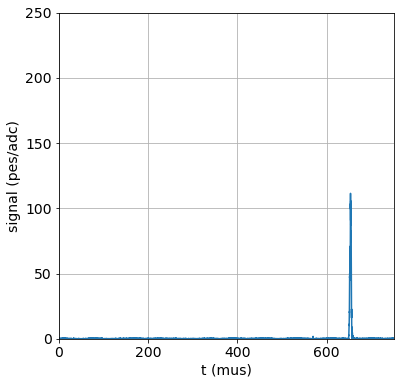

In [301]:
event=9
CWF  = blr.deconv_pmt(pmtrwf[event], coeff_c, coeff_blr, pmt_active, 
                      n_baseline            = 48000,
                      thr_trigger           =     5,
                      accum_discharge_length =  5000)
ccwfs, ccwfs_mau, cwf_sum, cwf_sum_mau = csf.calibrate_pmts(CWF, adc_to_pes)
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =0,
                            t_max      = 750,
                            signal_min =    0,
                            signal_max =  250,
                            figsize=(6,6))

In [302]:
s1_indx, s1_ene = pkf.indices_and_wf_above_threshold(cwf_sum_mau, 0.5 * units.pes)
s1s = pkf.find_peaks(cwf_sum_mau, s1_indx, s1params.time, s1params.length, s1params.stride, s1params.rebin_stride,
                    Pk=S1, pmt_ids=[-1], sipm_wfs=None, thr_sipm_s2=0)
s1s

[
       ---------------------
       S1 instance
       ---------------------
       Number of samples: 14
       Times: [ 569.55   569.575  569.6    569.625  569.65   569.675  569.7    569.725
 569.75   569.775  569.8    569.825  569.85   569.875] µs
       Time @ max energy: 569.6
       Width: 0.325 µs
       Height: 2.073827885586125 pes
       Energy: 17.36185837397461 pes
       Charge: 0.0 pes
       RMS: 0.10478783685251927 µs]

In [303]:
s2_indx, s2_ene = pkf.indices_and_wf_above_threshold(cwf_sum, 1.0 * units.pes)
s2s = pkf.find_peaks(cwf_sum, s2_indx, s2params.time, s2params.length, s2params.stride, s2params.rebin_stride,
                    Pk=S2, pmt_ids=[-1], sipm_wfs=None, thr_sipm_s2=0)
s2s

[
       ---------------------
       S2 instance
       ---------------------
       Number of samples: 10
       Times: [ 649.84970361  650.79383741  651.73136145  652.72197275  653.68352869
 654.64643625  655.54250662  656.51160592  657.63732477  658.33193941] µs
       Time @ max energy: 653.6835286937668
       Width: 8.482235807158519 µs
       Height: 3938.031004936889 pes
       Energy: 13770.108713956744 pes
       Charge: 0.0 pes
       RMS: 1.3877946459822856 µs]

## Event 10

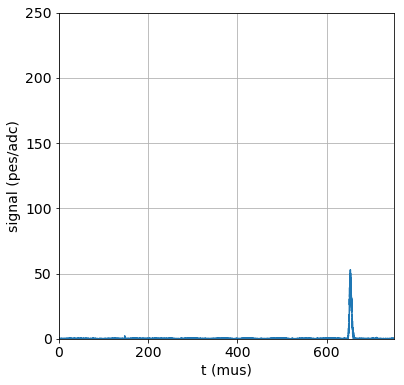

In [304]:
event=10
CWF  = blr.deconv_pmt(pmtrwf[event], coeff_c, coeff_blr, pmt_active, 
                      n_baseline            = 48000,
                      thr_trigger           =     5,
                      accum_discharge_length =  5000)
ccwfs, ccwfs_mau, cwf_sum, cwf_sum_mau = csf.calibrate_pmts(CWF, adc_to_pes)
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =0,
                            t_max      = 750,
                            signal_min =    0,
                            signal_max =  250,
                            figsize=(6,6))

In [305]:
s1_indx, s1_ene = pkf.indices_and_wf_above_threshold(cwf_sum_mau, 0.5 * units.pes)
s1s = pkf.find_peaks(cwf_sum_mau, s1_indx, s1params.time, s1params.length, s1params.stride, s1params.rebin_stride,
                    Pk=S1, pmt_ids=[-1], sipm_wfs=None, thr_sipm_s2=0)
s1s

[
       ---------------------
       S1 instance
       ---------------------
       Number of samples: 9
       Times: [ 147.575  147.6    147.625  147.65   147.675  147.7    147.725  147.75
 147.775] µs
       Time @ max energy: 147.625
       Width: 0.2 µs
       Height: 2.3934290144766055 pes
       Energy: 13.46626389688052 pes
       Charge: 0.0 pes
       RMS: 0.05634926171374194 µs]

In [306]:
s2_indx, s2_ene = pkf.indices_and_wf_above_threshold(cwf_sum, 1.0 * units.pes)
s2s = pkf.find_peaks(cwf_sum, s2_indx, s2params.time, s2params.length, s2params.stride, s2params.rebin_stride,
                    Pk=S2, pmt_ids=[-1], sipm_wfs=None, thr_sipm_s2=0)
s2s

[
       ---------------------
       S2 instance
       ---------------------
       Number of samples: 15
       Times: [ 647.55249109  648.55627173  649.48058611  650.5254044   651.44640067
 652.45211034  653.42355066  654.43965916  655.42630253  656.38625091
 657.40572341  658.40755677  659.28854567  660.36568539  661.31192533] µs
       Time @ max energy: 653.4235506645997
       Width: 13.75943424066226 µs
       Height: 1745.8932742827637 pes
       Energy: 10002.652303755838 pes
       Charge: 0.0 pes
       RMS: 2.305369152032575 µs]

## Event 11

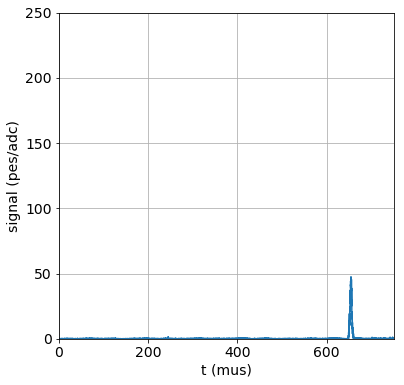

In [225]:
event=11
CWF  = blr.deconv_pmt(pmtrwf[event], coeff_c, coeff_blr, pmt_active, 
                      n_baseline            = 48000,
                      thr_trigger           =     5,
                      accum_discharge_length =  5000)
ccwfs, ccwfs_mau, cwf_sum, cwf_sum_mau = csf.calibrate_pmts(CWF, adc_to_pes)
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =0,
                            t_max      = 750,
                            signal_min =    0,
                            signal_max =  250,
                            figsize=(6,6))

## Event 12

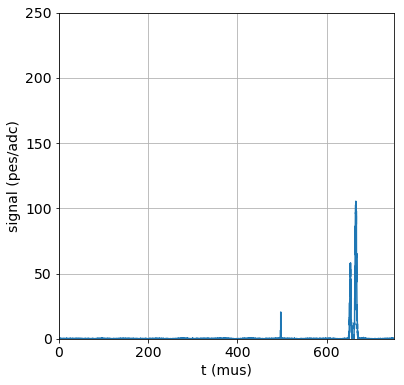

In [226]:
event=12
CWF  = blr.deconv_pmt(pmtrwf[event], coeff_c, coeff_blr, pmt_active, 
                      n_baseline            = 48000,
                      thr_trigger           =     5,
                      accum_discharge_length =  5000)
ccwfs, ccwfs_mau, cwf_sum, cwf_sum_mau = csf.calibrate_pmts(CWF, adc_to_pes)
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =0,
                            t_max      = 750,
                            signal_min =    0,
                            signal_max =  250,
                            figsize=(6,6))

In [227]:
s1_indx, s1_ene = pkf.indices_and_wf_above_threshold(cwf_sum_mau, 0.5 * units.pes)
s1s = pkf.find_peaks(cwf_sum_mau, s1_indx, s1params.time, s1params.length, s1params.stride, s1params.rebin_stride,
                    Pk=S1, pmt_ids=[-1], sipm_wfs=None, thr_sipm_s2=0)
s1s

[
 ---------------------
 S1 instance
 ---------------------
 Number of samples: 7
 Times: [ 496.775  496.8    496.825  496.85   496.875  496.9    496.925] µs
 Time @ max energy: 496.775
 Width: 0.15 µs
 Height: 6.605809338773452 pes
 Energy: 14.197269028562543 pes
 Charge: 0.0 pes
 RMS: 0.04818355210179539 µs, 
       ---------------------
       S1 instance
       ---------------------
       Number of samples: 13
       Times: [ 497.05   497.075  497.1    497.125  497.15   497.175  497.2    497.225
 497.25   497.275  497.3    497.325  497.35 ] µs
       Time @ max energy: 497.125
       Width: 0.3 µs
       Height: 20.541177326918575 pes
       Energy: 100.0469025479928 pes
       Charge: 0.0 pes
       RMS: 0.054568283494587276 µs]

In [228]:
s2_indx, s2_ene = pkf.indices_and_wf_above_threshold(cwf_sum, 0.5 * units.pes)
s2s = pkf.find_peaks(cwf_sum, s2_indx, s2params.time, s2params.length, s2params.stride, s2params.rebin_stride,
                    Pk=S2, pmt_ids=[-1], sipm_wfs=None, thr_sipm_s2=0)
s2s

[
       ---------------------
       S2 instance
       ---------------------
       Number of samples: 10
       Times: [ 649.56228295  650.47317083  651.43486631  652.39803258  653.31440892
 654.29931269  655.24944476  656.23508704  657.21250469  658.12037131] µs
       Time @ max energy: 653.3144089186528
       Width: 8.558088352676597 µs
       Height: 1968.1539270287822 pes
       Energy: 6962.745577520935 pes
       Charge: 0.0 pes
       RMS: 1.3327115713553053 µs, 
       ---------------------
       S2 instance
       ---------------------
       Number of samples: 12
       Times: [ 660.03872981  661.18376007  662.03736146  663.07415065  664.03328595
 664.99527226  665.98004362  666.91811677  667.90539964  668.86494109
 669.90398227  670.82579558] µs
       Time @ max energy: 665.9800436201225
       Width: 10.78706576955237 µs
       Height: 3823.545724505977 pes
       Energy: 15810.976558789143 pes
       Charge: 0.0 pes
       RMS: 1.523795679942792 µs, 
       --------

## Event 13 

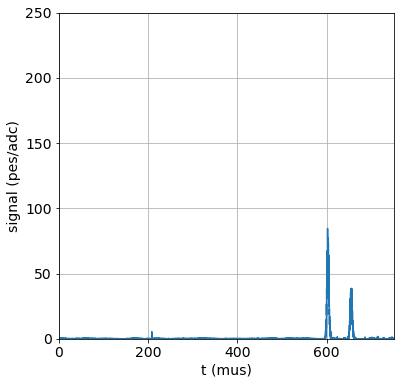

In [229]:
event=13
CWF  = blr.deconv_pmt(pmtrwf[event], coeff_c, coeff_blr, pmt_active, 
                      n_baseline            = 48000,
                      thr_trigger           =     5,
                      accum_discharge_length =  5000)
ccwfs, ccwfs_mau, cwf_sum, cwf_sum_mau = csf.calibrate_pmts(CWF, adc_to_pes)
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =0,
                            t_max      = 750,
                            signal_min =    0,
                            signal_max =  250,
                            figsize=(6,6))

In [230]:
s1_indx, s1_ene = pkf.indices_and_wf_above_threshold(cwf_sum_mau, 0.5 * units.pes)
s1s = pkf.find_peaks(cwf_sum_mau, s1_indx, s1params.time, s1params.length, s1params.stride, s1params.rebin_stride,
                    Pk=S1, pmt_ids=[-1], sipm_wfs=None, thr_sipm_s2=0)
s1s

[
       ---------------------
       S1 instance
       ---------------------
       Number of samples: 9
       Times: [ 208.125  208.15   208.175  208.2    208.225  208.25   208.275  208.3
 208.325] µs
       Time @ max energy: 208.2
       Width: 0.2 µs
       Height: 5.027431459421855 pes
       Energy: 18.946919014060164 pes
       Charge: 0.0 pes
       RMS: 0.04797742257456673 µs, 
       ---------------------
       S1 instance
       ---------------------
       Number of samples: 9
       Times: [ 208.525  208.55   208.575  208.6    208.625  208.65   208.675  208.7
 208.725] µs
       Time @ max energy: 208.6
       Width: 0.2 µs
       Height: 5.035823175455931 pes
       Energy: 26.667387768267556 pes
       Charge: 0.0 pes
       RMS: 0.049024103048667056 µs, 
       ---------------------
       S1 instance
       ---------------------
       Number of samples: 11
       Times: [ 605.025  605.05   605.075  605.1    605.125  605.15   605.175  605.2
 605.225  605.25   605.2

## Event 14

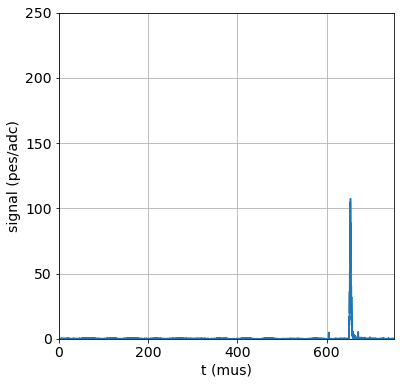

In [231]:
event=14
CWF  = blr.deconv_pmt(pmtrwf[event], coeff_c, coeff_blr, pmt_active, 
                      n_baseline            = 48000,
                      thr_trigger           =     5,
                      accum_discharge_length =  5000)
ccwfs, ccwfs_mau, cwf_sum, cwf_sum_mau = csf.calibrate_pmts(CWF, adc_to_pes)
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =0,
                            t_max      = 750,
                            signal_min =    0,
                            signal_max =  250,
                            figsize=(6,6))

In [232]:
s1_indx, s1_ene = pkf.indices_and_wf_above_threshold(cwf_sum_mau, 0.5 * units.pes)
s1s = pkf.find_peaks(cwf_sum_mau, s1_indx, s1params.time, s1params.length, s1params.stride, s1params.rebin_stride,
                    Pk=S1, pmt_ids=[-1], sipm_wfs=None, thr_sipm_s2=0)
s1s

[
 ---------------------
 S1 instance
 ---------------------
 Number of samples: 5
 Times: [ 604.425  604.45   604.475  604.5    604.525] µs
 Time @ max energy: 604.425
 Width: 0.1 µs
 Height: 4.117100535570109 pes
 Energy: 11.515941072872241 pes
 Charge: 0.0 pes
 RMS: 0.03401738088166526 µs, 
       ---------------------
       S1 instance
       ---------------------
       Number of samples: 11
       Times: [ 604.8    604.825  604.85   604.875  604.9    604.925  604.95   604.975
 605.     605.025  605.05 ] µs
       Time @ max energy: 604.85
       Width: 0.25 µs
       Height: 4.963517788028963 pes
       Energy: 19.33255615861085 pes
       Charge: 0.0 pes
       RMS: 0.057628944674135346 µs]

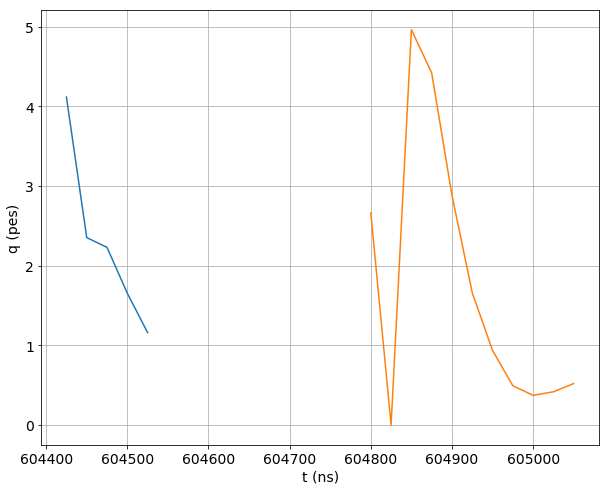

In [235]:
plot_S12(s1s)

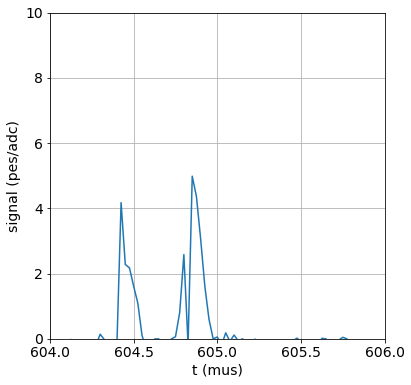

In [236]:
sf.plot_signal_vs_time_mus(cwf_sum,
                            t_min      =604,
                            t_max      = 606,
                            signal_min =    0,
                            signal_max =  10,
                            figsize=(6,6))

- double peak 

In [233]:
s2_indx, s2_ene = pkf.indices_and_wf_above_threshold(cwf_sum, 0.5 * units.pes)
s2s = pkf.find_peaks(cwf_sum, s2_indx, s2params.time, s2params.length, s2params.stride, s2params.rebin_stride,
                    Pk=S2, pmt_ids=[-1], sipm_wfs=None, thr_sipm_s2=0)
s2s

[
       ---------------------
       S2 instance
       ---------------------
       Number of samples: 24
       Times: [ 649.97256702  650.85940532  651.81317312  652.74120509  653.68362281
 654.64899891  655.64668553  656.62137897  657.65051172  658.64018987
 659.69752855  660.68526807  661.70856991  662.73226555  663.58966674
 664.87555144  665.52118644  666.59838335  667.80658891  668.8330554
 669.88063769  670.64495109  671.56192234  672.40863972] µs
       Time @ max energy: 652.7412050888942
       Width: 22.436072699109676 µs
       Height: 3458.4477805388606 pes
       Energy: 13568.671354380818 pes
       Charge: 0.0 pes
       RMS: 2.2617272810180067 µs, 
 ---------------------
 S2 instance
 ---------------------
 Number of samples: 4
 Times: [ 684.38088716  685.4702863   686.31532697  687.15983389] µs
 Time @ max energy: 685.4702862950182
 Width: 2.778946730725933 µs
 Height: 9.196595674018745 pes
 Energy: 21.559413476497205 pes
 Charge: 0.0 pes
 RMS: 0.8195194272801225 µ

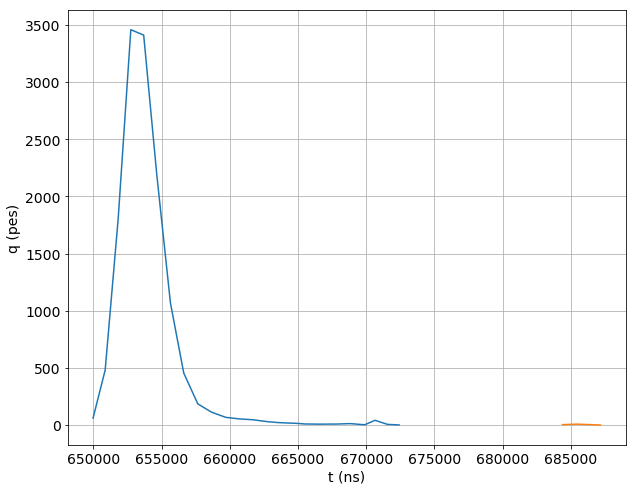

In [234]:
plot_S12(s2s)

In [272]:
s2_indx, s2_ene = pkf.indices_and_wf_above_threshold(cwf_sum, 1.0 * units.pes)
s2s = pkf.find_peaks(cwf_sum, s2_indx, s2params.time, s2params.length, s2params.stride, s2params.rebin_stride,
                    Pk=S2, pmt_ids=[-1], sipm_wfs=None, thr_sipm_s2=0)
s2s

[
       ---------------------
       S2 instance
       ---------------------
       Number of samples: 14
       Times: [ 648.70072653  649.66381752  650.678766    651.65606818  652.63988717
 653.61900037  654.61594392  655.58320442  656.56569644  657.56725464
 658.53077067  659.5430227   660.51445007  661.62537538] µs
       Time @ max energy: 654.6159439229183
       Width: 12.92464885085111 µs
       Height: 2203.562850790142 pes
       Energy: 12362.19259177607 pes
       Charge: 0.0 pes
       RMS: 2.2591161145243 µs]

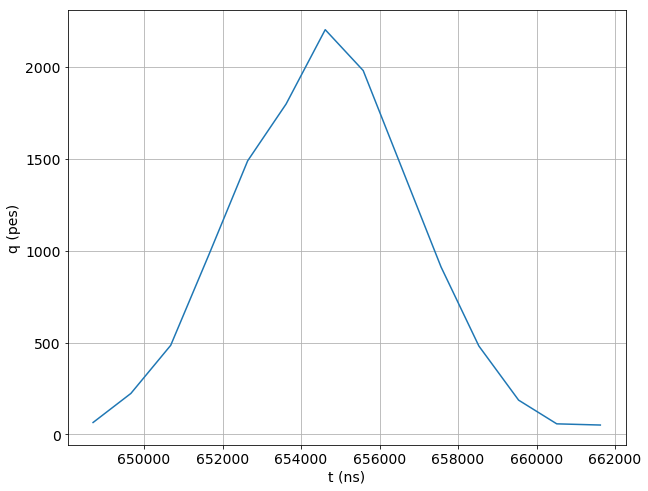

In [273]:
plot_S12(s2s)

### Conclusions

- Deconvolution correct
- S1 doubling. Effect not understood.
- S2 cut at 1 pes kills tails.
- We seem to have very little Krypton and some background
- Lifetime may be good, but needs to be measured.